In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

#tested usage of reference star I to correct unresolved polarisation. Interesting, but does not solve the problem fully

def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi



In [2]:
def load_and_make_polar_correction(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            mask=(R<=3)

            q_over_i=np.divide(q,i,where=i!=0)   
            cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
            u_over_i=np.divide(u,i,where=i!=0)    
            cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
            q_corr=q#-cq*iq
            u_corr=u#-cu*iu

            q_phi=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
            q_phi= (q_phi> 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
            pi=np.sqrt(q_corr*q_corr+u_corr*u_corr)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q_corr,iu,u_corr,i,q_phi,u_phi,pi,aolp,R,phi


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def Loadimagespsf_AR(star):
    dir = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/classic_reduction/'+star+'/'
 
    psfile =  '*REDUCED_I.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSFv = hdulPSF[0].data[0]
            PSFi = hdulPSF[0].data[1]

            
    return PSFv,PSFi


In [3]:
#For fits
#out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
#out_fits.writeto(dirName+star+'_'+annulus+'_'+fittype+'_decon.fits', overwrite = True)                       # write output

stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']

star='AR_Pup_dc_notnorm'

starnames = {'HD75885':'HD75885','AR_Pup':'AR_Pup','HR4049/2019-01-08':'HR4049-2019-01-08','HR4049/2019-01-07':'HR4049-2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'UMon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709_Car','UMon_calibV390':'UMon_calibV390','HR4224':'HR4224'}
fittypes=['1', '2']

band=['V','I']
ps=3.6


if star=='AR_Pup':
    dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
    input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    
if star=='AR_Pup_dc_notnorm':
    dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
    input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'#


if star=='IRAS08544-4431':
    dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
    input_filename =dirdat+'IRAS08process_list.csv'
if star=='IRAS08544-4431_dc_notnorm':
    dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
    input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
table = pd.read_csv(input_filename)
table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

output_filename = dirdat+star+'_V_Original_AP_per_cycle.txt'
df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
output_filename = dirdat+star+'_I_Original_AP_per_cycle.txt'
df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

#stars = ['HD75885','AR_Pup','HR4049/2019-01-08','HR4049/2019-01-07','IRAS08544-4431','UMon','V709_Car','UMon_calibV390','HR4224']


processes=table['id']

reference={process:ref for process,ref in zip(table['id'], table['reference'])}
process_dict={ref:process for process,ref in zip(table['id'], table['reference'])}

percentile_25 = np.percentile(df_orig_v['FWHM'], 80)


#filtering list of processes
filtered_process_dict = {key: value for key, value in process_dict.items() if df_orig_v[df_orig_v['reference'] == key]['FWHM'].values[0] <=percentile_25}

print(filtered_process_dict)
print(len(filtered_process_dict))

{'AR_Pup_20c_00_17-19_not_norm': 481361, 'AR_Pup_19c_00_15-17(1)_not_norm': 481360, 'AR_Pup_18c_00_14-15(1)_not_norm': 481359, 'AR_Pup_17c_00_12-13_not_norm': 481358, 'AR_Pup_16c_00_10-11_not_norm': 481357, 'AR_Pup_15c_00_08-09_not_norm': 481356, 'AR_Pup_14c_00_06-07_not_norm': 481355, 'AR_Pup_13c_00_04-05_not_norm': 481354, 'AR_Pup_12c_00_02-03_not_norm': 481353, 'AR_Pup_11c_00_00-02(1)_not_norm': 481352, 'AR_Pup_10c_23_58-00(1)_not_norm': 481351, 'AR_Pup_9c_23_56-58(1)_not_norm': 481350, 'AR_Pup_8c_23_54-56(1)_not_norm': 481349, 'AR_Pup_7c_23_53-54(1)_not_norm': 481348, 'AR_Pup_6c_23_51-52_not_norm': 481347, 'AR_Pup_4c_23_47-48_not_norm': 481345, 'AR_Pup_3c_23_45-46_not_norm': 481344, 'AR_Pup_2c_23_43-44_not_norm': 481343, 'AR_Pup_1c_23_41-42_not_norm': 481342}
19



reference                                max_DoLP[%] max_Q_phi  max_PI     sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 

V
(19, 1024, 1024)
AR_Pup_dc_notnorm                        23.355     105.971    114.940    5.675      5.012      8.733      



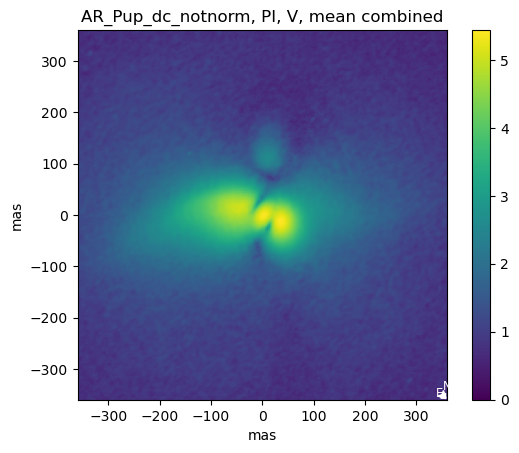

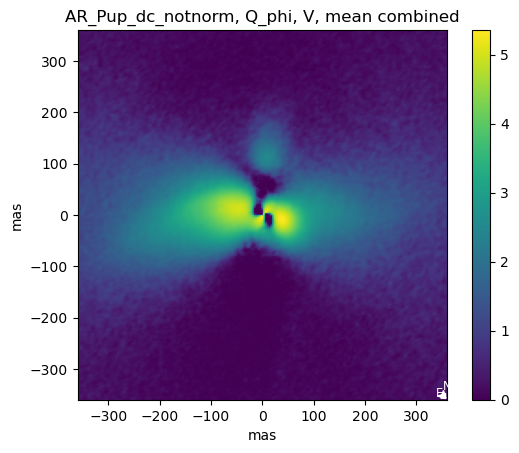

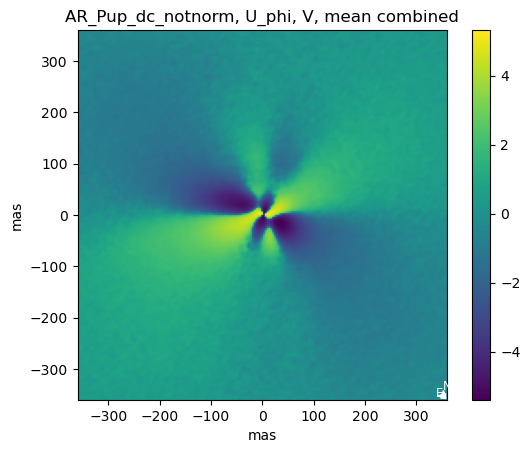

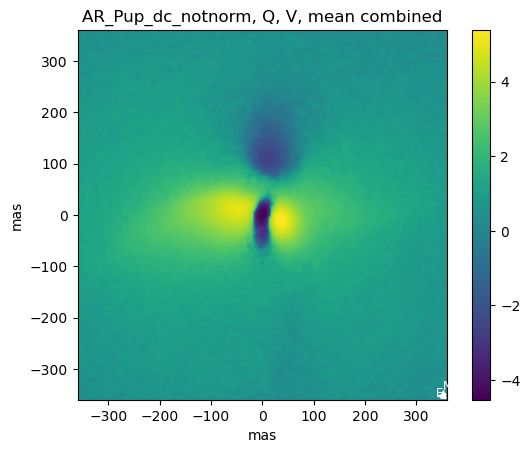

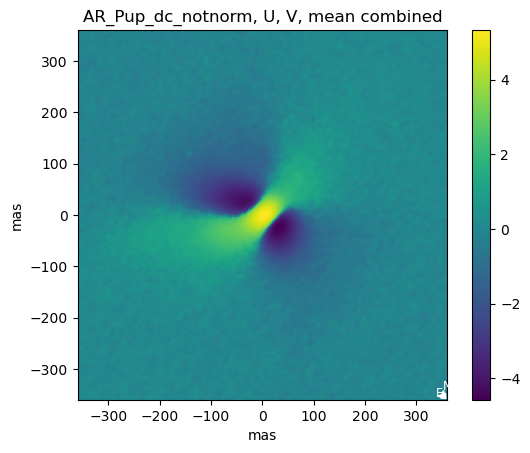

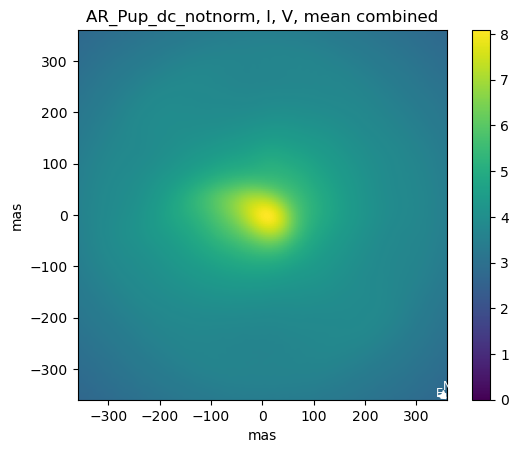

AR_Pup_dc_notnorm corr for unres         31.440     158.115    163.023    9.605      7.204      12.417     



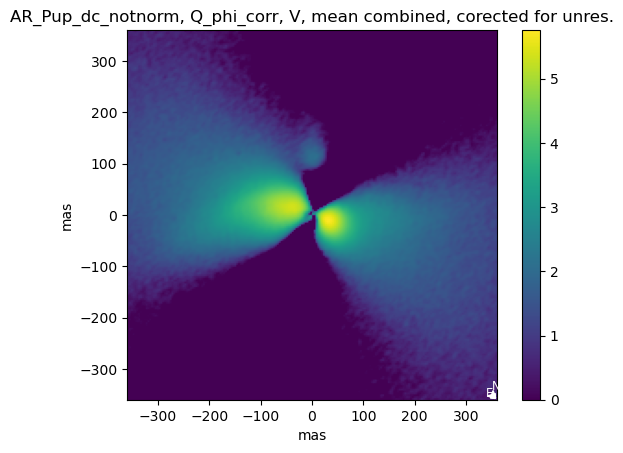

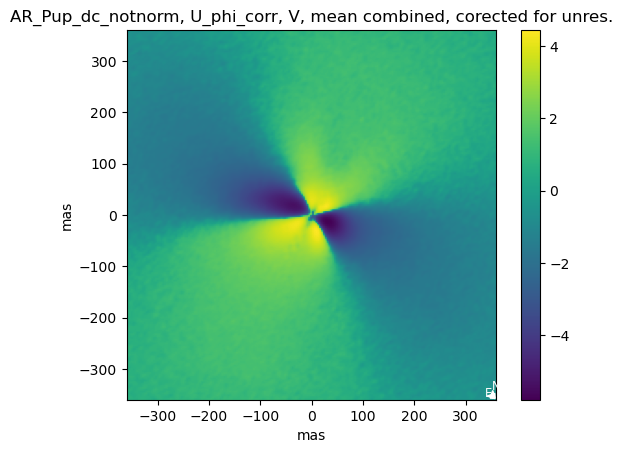

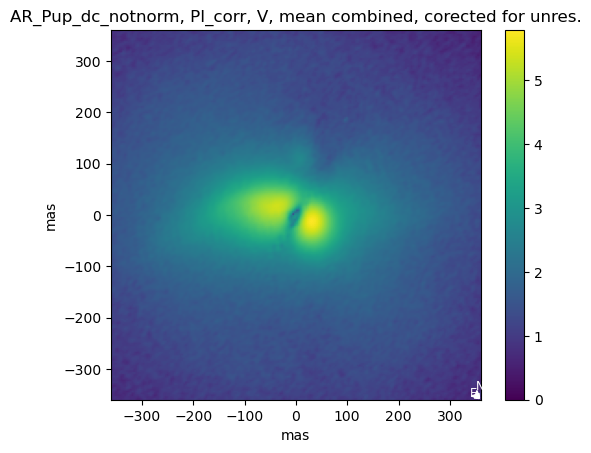

I
(19, 1024, 1024)
AR_Pup_dc_notnorm                        25.847     255.117    287.980    1.761      5.490      9.005      



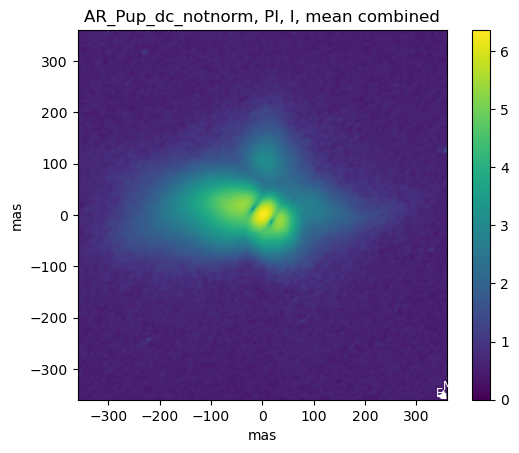

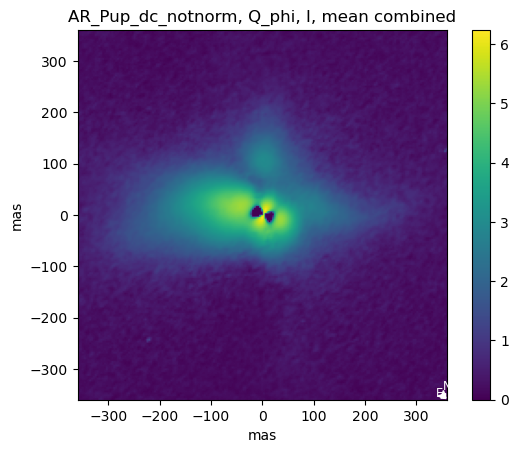

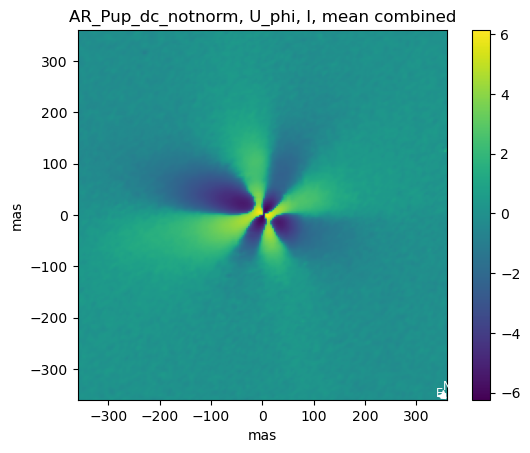

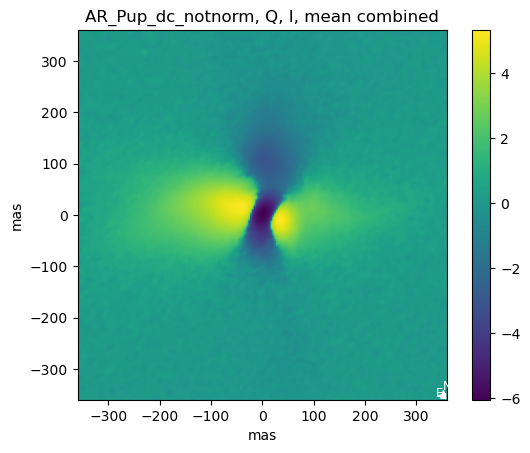

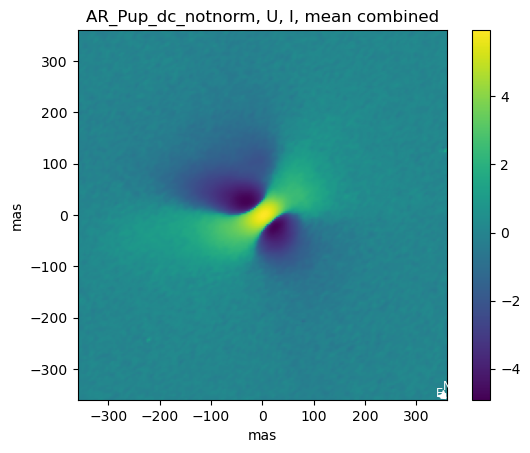

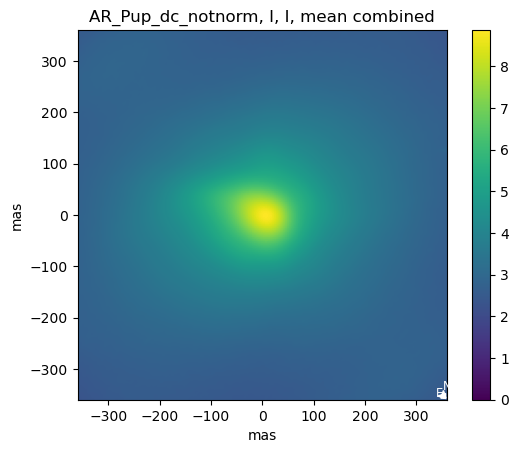

AR_Pup_dc_notnorm corr for unres         28.209     146.586    151.897    5.331      5.667      7.447      



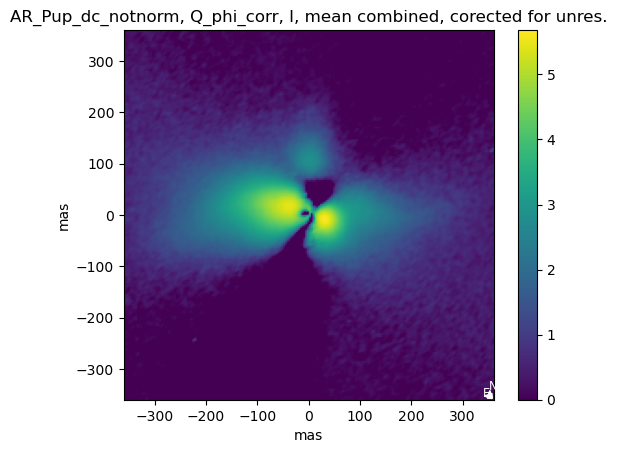

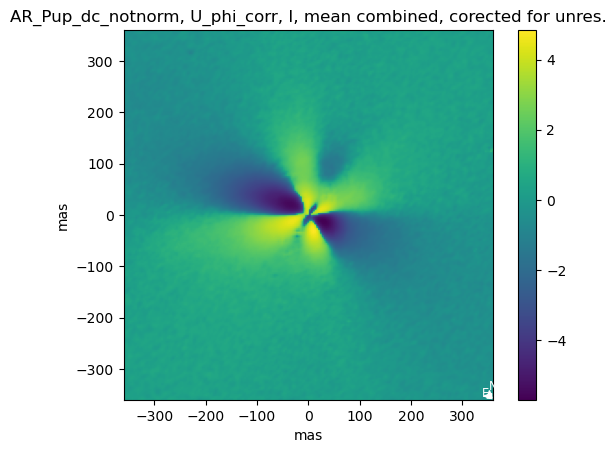

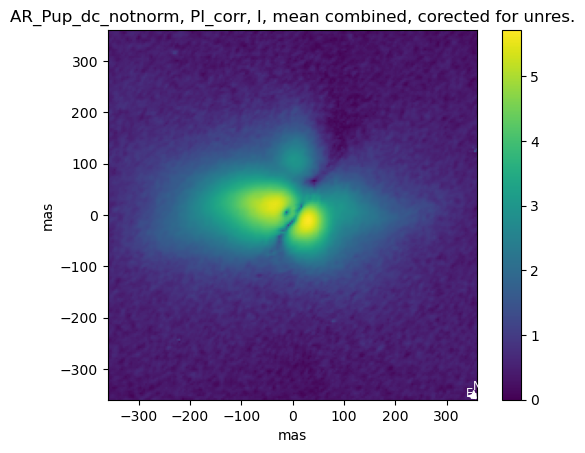

In [5]:
#Images of the mean_combined data

figfolder=dirdat+'mean_combined_AR_PUP_test/'
createfolder(figfolder)
print("{:<40} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))



for fittype in fittypes:
    print(band[int(fittype)-1])
    dirName=dirdat+'SPHERE_DC_DATA/'+str(processes[0])+'/'
    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)
    iq_arr=[]
    iu_arr=[]
    q_arr=[]
    u_arr=[]
    i_arr=[]
    q_phi_arr=[]
    u_phi_arr=[]
    pi_arr=[]
    
    for process in filtered_process_dict.values():
        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)
        iq_arr.append(iq)
        iu_arr.append(iu)
        q_arr.append(q)
        u_arr.append(u)
        i_arr.append(i)
        q_phi_arr.append(q_phi)
        u_phi_arr.append(u_phi)
        pi_arr.append(pi)

    iq_arr=np.array(iq_arr)
    iu_arr=np.array(iu_arr)
    q_arr=np.array(q_arr)
    u_arr=np.array(u_arr)
    q_phi_arr=np.array(q_phi_arr)
    u_phi_arr=np.array(u_phi_arr)
    pi_arr=np.array(pi_arr)
    i_arr=np.array(i_arr)
    
    print(q_arr.shape)
    
    q_mean_comb=np.mean(q_arr,axis=0)
    u_mean_comb=np.mean(u_arr,axis=0)
    iq_mean_comb=np.mean(iq_arr,axis=0)
    iu_mean_comb=np.mean(iu_arr,axis=0)
    i_mean_comb=np.mean(i_arr,axis=0)
    pi_mean_comb=np.mean(pi_arr,axis=0)
    q_phi_mean_comb=np.mean(q_phi_arr,axis=0)
    u_phi_mean_comb=np.mean(u_phi_arr,axis=0)
    
        
    n=q_mean_comb.shape[0]
    if star=='AR_Pup' or star=='AR_Pup_dc_notnorm':
        lim=100       
    else:
        lim=50       
            
    
    
    frac =np.max(np.divide(q_phi_mean_comb,i_mean_comb,where=i_mean_comb!=0)*(R<=150))*100
    mask=(R<=200)
    q_sum=np.sum(q_mean_comb[mask])
    qphi_sum=np.sum(q_phi_mean_comb[mask])
    I_sum=np.sum(i_mean_comb[mask])
    pi_sum=np.sum(pi_mean_comb[mask])

    fwhm=find_FWHM (i_mean_comb,n,ps,figfolder,band[int(fittype)-1]+'_gauss_mean_combined')
    #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
    mask=(R<=1500/ps)
    
    #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
    normalisation=np.sum(i_mean_comb[mask])
    peak_i=np.max(i_mean_comb*(R<200))/normalisation
    peak_pi=np.max(pi_mean_comb*(R<200))/normalisation
    peak_q_phi=np.max(q_phi_mean_comb*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center
    
    line = "{:<40} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} \n".format(star,
        frac, np.max(q_phi_mean_comb), np.max(pi_mean_comb), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
    print(line)
        
    
    
    filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

    for fileindex,image1 in enumerate([pi_mean_comb,q_phi_mean_comb, u_phi_mean_comb,q_mean_comb,u_mean_comb,i_mean_comb]):
        out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
        out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_meancombined.fits', overwrite = True)                       # write output

        image_an = image1*(R<250)
        image=np.arcsinh(image_an)
        fig, ax = plt.subplots()
        f.plottingroutinemas(image,lim,ps,n,star,ax)        
        f.scale_mas(star,ax)  

        plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', mean combined') 
        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+'_meancombined.jpeg',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


       
    
#corrected for unresolved
    if star=='AR_Pup' or star=='AR_Pup_dc_notnorm':
        PSFv,PSFi = Loadimagespsf_AR('HD75885')
        if band[int(fittype)-1]=='V':
            iq_mean_comb==PSFv*1.0
            iu_mean_comb==PSFv*1.0

        if band[int(fittype)-1]=='I':
            iq_mean_comb=PSFi*1.0
            iu_mean_comb=PSFi*1.0
    
    correction_radius=3
    mask=(R<=correction_radius)

    q_over_i=np.divide(q_mean_comb,i_mean_comb,where=i_mean_comb!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u_mean_comb,i_mean_comb,where=i_mean_comb!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    q_corr=q_mean_comb-cq*iq_mean_comb
    u_corr=u_mean_comb-cu*iu_mean_comb
    
    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
    q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-10
    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
    aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2
    angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))
    if angleofpol<0: angleofpol+=180

    frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=150))*100
    mask=(R<=100)
    q_sum=np.sum(q_corr[mask])
    qphi_sum=np.sum(q_phi_corr[mask])
    I_sum=np.sum(i[mask])
    pi_sum=np.sum(pi_corr[mask])
    
    
    line = "{:<40} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} \n".format(star+' corr for unres',
        frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
    print(line)
    


    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_meancombined_corunresolved')
    #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
    mask=(R<=1500/ps)

    middle=int(n/2)
    ctn6=i*np.sum(i[mask])/10e6
    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

    #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
    normalisation=np.sum(i[mask])
    peak_i=np.max(i*(R<200))/normalisation
    peak_pi=np.max(pi_corr*(R<200))/normalisation
    peak_q_phi=np.max(q_phi_corr*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center

    filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

    for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
        out_fits = fits.HDUList(fits.PrimaryHDU(image1))                  # create output fits structure
        out_fits.writeto(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_meancombined_corunresolved.fits', overwrite = True)                       # write output

        image_an = image1*(R<250)
        image=np.arcsinh(image_an)
        fig, ax = plt.subplots()
        f.plottingroutinemas(image,lim,ps,n,star,ax)        
        f.scale_mas(star,ax)  

        plt.title(star+', '+filename[fileindex]+', '+band[int(fittype)-1]+', mean combined, corected for unres.') 
        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+filename[fileindex]+'_meancombined_corunresolved.jpeg',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()
            


In [5]:
#Parameters of the mean_combined data
stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']


figfolder=dirdat+'mean_combined/'
createfolder(figfolder)
print("{:<40} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} \n".format('reference',"max_DoLP[%]",'std(max_DOLP[%])', "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]"))


for star in stars:
    
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    if star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'#


    if star=='IRAS08544-4431':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    if star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'

    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    output_filename = dirdat+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = dirdat+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}
    process_dict={ref:process for process,ref in zip(table['id'], table['reference'])}

    percentile_25 = np.percentile(df_orig_v['FWHM'], 80)
    #filtering list of processes
    filtered_process_dict = {key: value for key, value in process_dict.items() if df_orig_v[df_orig_v['reference'] == key]['FWHM'].values[0] <=percentile_25}

        
        
    for fittype in fittypes:
        print(band[int(fittype)-1])
        dirName=dirdat+'SPHERE_DC_DATA/'+str(processes[0])+'/'
        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)
        iq_arr=[]
        iu_arr=[]
        q_arr=[]
        u_arr=[]
        i_arr=[]
        q_phi_arr=[]
        u_phi_arr=[]
        pi_arr=[]

        for process in filtered_process_dict.values():
            dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
            iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)
            iq_arr.append(iq)
            iu_arr.append(iu)
            q_arr.append(q)
            u_arr.append(u)
            i_arr.append(i)
            q_phi_arr.append(q_phi)
            u_phi_arr.append(u_phi)
            pi_arr.append(pi)

        iq_arr=np.array(iq_arr)
        iu_arr=np.array(iu_arr)
        q_arr=np.array(q_arr)
        u_arr=np.array(u_arr)
        q_phi_arr=np.array(q_phi_arr)
        u_phi_arr=np.array(u_phi_arr)
        pi_arr=np.array(pi_arr)
        i_arr=np.array(i_arr)
        
        q_mean_comb=np.mean(q_arr,axis=0)
        u_mean_comb=np.mean(u_arr,axis=0)
        iq_mean_comb=np.mean(iq_arr,axis=0)
        iu_mean_comb=np.mean(iu_arr,axis=0)
        i_mean_comb=np.mean(i_arr,axis=0)
        pi_mean_comb=np.mean(pi_arr,axis=0)
        q_phi_mean_comb=np.mean(q_phi_arr,axis=0)
        u_phi_mean_comb=np.mean(u_phi_arr,axis=0)


        n=q_mean_comb.shape[0]
        if star=='AR_Pup' or star=='AR_Pup_dc_notnorm':
            lim=100       
        else:
            lim=50       

        frac =np.max(np.divide(q_phi_mean_comb,i_mean_comb,where=i_mean_comb!=0)*(R<=150))*100
        if fittype=='1':
            std_frac=np.std(df_orig_v['max_DoLP[%]'])
        if fittype=='2':
            std_frac=np.std(df_orig_i['max_DoLP[%]'])
        mask=(R<=200)
        q_sum=np.sum(q_mean_comb[mask])
        qphi_sum=np.sum(q_phi_mean_comb[mask])
        I_sum=np.sum(i_mean_comb[mask])
        pi_sum=np.sum(pi_mean_comb[mask])

        fwhm=find_FWHM (i_mean_comb,n,ps,figfolder,band[int(fittype)-1]+'_gauss_mean_combined')
        #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
        mask=(R<=1500/ps)

        #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
        normalisation=np.sum(i_mean_comb[mask])
        peak_i=np.max(i_mean_comb*(R<200))/normalisation
        peak_pi=np.max(pi_mean_comb*(R<200))/normalisation
        peak_q_phi=np.max(q_phi_mean_comb*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center

        line = "{:<40} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} \n".format(star,
            frac,std_frac, np.max(q_phi_mean_comb), np.max(pi_mean_comb), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)

        if (star!='AR_Pup') and (star!='AR_Pup_dc_notnorm'):
        #corrected for unresolved
            correction_radius=3
            mask=(R<=correction_radius)

            q_over_i=np.divide(q_mean_comb,i_mean_comb,where=i_mean_comb!=0)   
            cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
            u_over_i=np.divide(u_mean_comb,i_mean_comb,where=i_mean_comb!=0)    
            cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
            q_corr=q_mean_comb-cq*iq_mean_comb
            u_corr=u_mean_comb-cu*iu_mean_comb

            q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
            q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-10
            u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
            pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
            aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2
            angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))
            if angleofpol<0: angleofpol+=180

            frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=150))*100
            mask=(R<=100)
            q_sum=np.sum(q_corr[mask])
            qphi_sum=np.sum(q_phi_corr[mask])
            I_sum=np.sum(i[mask])
            pi_sum=np.sum(pi_corr[mask])


            line = "{:<40} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} \n".format(star+' corr for unres',
                frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100)
            print(line)



            fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_meancombined_corunresolved')
            #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
            mask=(R<=1500/ps)

            middle=int(n/2)
            ctn6=i*np.sum(i[mask])/10e6
            cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

            #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
            normalisation=np.sum(i[mask])
            peak_i=np.max(i*(R<200))/normalisation
            peak_pi=np.max(pi_corr*(R<200))/normalisation
            peak_q_phi=np.max(q_phi_corr*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center







reference                                max_DoLP[%] std(max_DOLP[%]) max_Q_phi  max_PI     sumQ/I[%]  sumQ_phi/I[%] sumPI/I[%] 

V
20709567.3594073
IRAS08544-4431                           20.827     20709567.359 72.152     81.771     -0.012     1.027      2.473      

IRAS08544-4431 corr for unres            27.377     67.930     68.312     0.170      0.489      0.641      

I
20709567.3594073
IRAS08544-4431                           18.537     2490925997.726 60.102     60.291     -0.016     1.479      3.389      

IRAS08544-4431 corr for unres            14.214     55.984     56.156     0.139      0.755      0.912      

V
4065827.7974003316
IRAS08544-4431_dc_notnorm                20.562     4065827.797 356.115    398.734    1.847      1.340      3.469      

IRAS08544-4431_dc_notnorm corr for unres 25.247     67.315     67.915     0.162      0.492      0.642      

I
4065827.7974003316
IRAS08544-4431_dc_notnorm                17.262     13667274.491 246.307    264.277    1.228   

In [6]:
for star in stars:

    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    if star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'#


    if star=='IRAS08544-4431':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    if star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'


    output_filename = dirdat+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = dirdat+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

    #stars = ['HD75885','AR_Pup','HR4049/2019-01-08','HR4049/2019-01-07','IRAS08544-4431','UMon','V709_Car','UMon_calibV390','HR4224']

    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}
    process_dict={ref:process for process,ref in zip(table['id'], table['reference'])}

    percentile = np.percentile(df_orig_v['FWHM'], 80)
    #filtering list of processes
    filtered_process_dict = {key: value for key, value in process_dict.items() if df_orig_v[df_orig_v['reference'] == key]['FWHM'].values[0] <=percentile}


    figfolder=dirdat+'mean_combined/'
    createfolder(figfolder)
    print(star)


    for fittype in fittypes:
        print(band[int(fittype)-1])
        totalnum=0
        iq_arr=[]
        iu_arr=[]
        q_arr=[]
        u_arr=[]
        i_arr=[]
        q_phi_arr=[]
        u_phi_arr=[]
        pi_arr=[]

        for process in filtered_process_dict.values():
            totalnum+=1
            dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
            iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)
            iq_arr.append(iq)
            iu_arr.append(iu)
            q_arr.append(q)
            u_arr.append(u)
            i_arr.append(i)
            q_phi_arr.append(q_phi)
            u_phi_arr.append(u_phi)
            pi_arr.append(pi)

        iq_arr=np.array(iq_arr)
        iu_arr=np.array(iu_arr)
        q_arr=np.array(q_arr)
        u_arr=np.array(u_arr)
        q_phi_arr=np.array(q_phi_arr)
        u_phi_arr=np.array(u_phi_arr)
        pi_arr=np.array(pi_arr)
        i_arr=np.array(i_arr)



        q_mean_comb=np.mean(q_arr,axis=0)
        u_mean_comb=np.mean(u_arr,axis=0)
        iq_mean_comb=np.mean(iq_arr,axis=0)
        iu_mean_comb=np.mean(iu_arr,axis=0)
        i_mean_comb=np.mean(i_arr,axis=0)
        pi_mean_comb=np.mean(pi_arr,axis=0)
        q_phi_mean_comb=np.mean(q_phi_arr,axis=0)
        u_phi_mean_comb=np.mean(u_phi_arr,axis=0)

        q_median_comb=np.median(q_arr,axis=0)
        u_median_comb=np.median(u_arr,axis=0)
        iq_median_comb=np.median(iq_arr,axis=0)
        iu_median_comb=np.median(iu_arr,axis=0)
        i_median_comb=np.median(i_arr,axis=0)
        pi_median_comb=np.median(pi_arr,axis=0)
        q_phi_median_comb=np.median(q_phi_arr,axis=0)
        u_phi_median_comb=np.median(u_phi_arr,axis=0)



        pidiff=[]
        q_phidiff=[]

        for i in range(0,iq_arr.shape[0]):
            q_phidiff.append(np.sum(abs((q_phi_median_comb-q_phi_arr[i]))*(R<50))/np.sum(q_phi_mean_comb*(R<50)))
            pidiff.append(np.sum(abs((pi_median_comb-pi_arr[i]))*(R<50))/np.sum(pi_mean_comb*(R<50)))

        print('max ratio of sum q_phi_diff to total q_phi signal ',np.max(q_phidiff))
        print('max ratio of sum pi_diff to total pi signal ', np.max(pidiff))




IRAS08544-4431
V
max ratio of sum q_phi_diff to total q_phi signal  0.4827629667638254
max ratio of sum pi_diff to total pi signal  0.35345882
I
max ratio of sum q_phi_diff to total q_phi signal  0.36811965584453327
max ratio of sum pi_diff to total pi signal  0.29350883

IRAS08544-4431_dc_notnorm
V
max ratio of sum q_phi_diff to total q_phi signal  0.3501782711950912
max ratio of sum pi_diff to total pi signal  0.31375885
I
max ratio of sum q_phi_diff to total q_phi signal  0.29409947377775475
max ratio of sum pi_diff to total pi signal  0.2251928

AR_Pup
V
max ratio of sum q_phi_diff to total q_phi signal  0.2360011374825277
max ratio of sum pi_diff to total pi signal  0.22581357
I
max ratio of sum q_phi_diff to total q_phi signal  0.169055551422381
max ratio of sum pi_diff to total pi signal  0.16215278

AR_Pup_dc_notnorm
V
max ratio of sum q_phi_diff to total q_phi signal  0.21268193046575393
max ratio of sum pi_diff to total pi signal  0.19843647
I
max ratio of sum q_phi_diff to 

0-3

AR_Pup_20c_00_17-19_not_norm
AR_Pup_19c_00_15-17(1)_not_norm
AR_Pup_18c_00_14-15(1)_not_norm
AR_Pup_17c_00_12-13_not_norm
AR_Pup_16c_00_10-11_not_norm
AR_Pup_15c_00_08-09_not_norm
AR_Pup_14c_00_06-07_not_norm
AR_Pup_13c_00_04-05_not_norm
AR_Pup_12c_00_02-03_not_norm
AR_Pup_11c_00_00-02(1)_not_norm
AR_Pup_10c_23_58-00(1)_not_norm
AR_Pup_9c_23_56-58(1)_not_norm
AR_Pup_8c_23_54-56(1)_not_norm
AR_Pup_7c_23_53-54(1)_not_norm
AR_Pup_6c_23_51-52_not_norm
AR_Pup_5c_23_49-50_not_norm
AR_Pup_4c_23_47-48_not_norm
AR_Pup_3c_23_45-46_not_norm
AR_Pup_2c_23_43-44_not_norm
AR_Pup_1c_23_41-42_not_norm
AR_Pup_20c_00_17-19_not_norm
AR_Pup_19c_00_15-17(1)_not_norm
AR_Pup_18c_00_14-15(1)_not_norm


KeyboardInterrupt: 